In [1]:
import gc
import os
import sys
import glob
import time
import zipfile
import argparse
import datetime
import warnings
import traceback

import numpy as np
import pandas as pd
import dask
import tqdm
import dask.bag as db
from dask.diagnostics import ProgressBar
import pyart

import pandas as pd
import matplotlib.pyplot as pl
from matplotlib.colors import LogNorm

import seaborn as sns
from scipy.stats import mode

In [2]:
warnings.simplefilter('ignore')
sns.set()
sns.set_style('white')

In [3]:
import suncal
from suncal import SunNotFoundError

In [4]:
flist = sorted(glob.glob('/g/data/hj10/admin/opol/level_1/in2020_hobart/**/*.*'))

In [5]:
def savedata(rslt_list, path='/scratch/kl02/vhl548/solar_output/opol'):
    '''
    Save the output data into a CSV file compatible with pandas.

    Parameters:
    ===========
    rslt_list: list
        List of solar calibration results for the given date.
    path: str
        Output directory.
    '''
    RID = 'OPOL'
    df = pd.concat(rslt_list).reset_index()
    dtime = df.time[0].strftime('%Y%m%d')
    year = df.time[0].strftime('%Y')

    path = os.path.join(path, RID)
    mkdir(path)
    path = os.path.join(path, year)
    mkdir(path)

    outfilename = os.path.join(path, f'suncal.{RID}.{dtime}.csv')
    df.to_csv(outfilename)
#     print(crayons.green(f'{len(df)} solar hits on {dtime}.'))
#     print(crayons.green(f'Results saved in {outfilename}.'))

    return None

In [6]:
def buffer(infile):
    '''
    Buffer function to catch and kill errors about missing Sun hit.

    Parameters:
    ===========
    infile: str
        Input radar file.

    Returns:
    ========
    rslt: pd.DataFrame
        Pandas dataframe with the results from the solar calibration code.
    '''
    try:
        rslt = suncal.sunpos_reflectivity(infile)
    except SunNotFoundError:
        return None

    return rslt

In [7]:
def mkdir(path):
    '''
    Create the DIRECTORY(ies), if they do not already exist
    '''
    try:
        os.mkdir(path)
    except FileExistsError:
        pass

    return None

In [8]:
def chunks(l, n):
    """
    Yield successive n-sized chunks from l.
    From http://stackoverflow.com/a/312464
    """
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [9]:
# for fchunk in tqdm.tqdm_notebook(chunks(flist, 128), total=len(flist) // 128):
bag = db.from_sequence(flist).map(buffer)
with ProgressBar():
    rslt = bag.compute()

rslt = [r for r in rslt if r is not None]
print(f'There is {len(rslt)} file(s)')
# if len(rslt) == 0:
#     continue
# savedata(rslt)

[########################################] | 100% Completed |  6min 26.9s
Theres 293 files


# Stats on solar cal.

In [10]:
df = pd.concat(rslt, ignore_index=True)

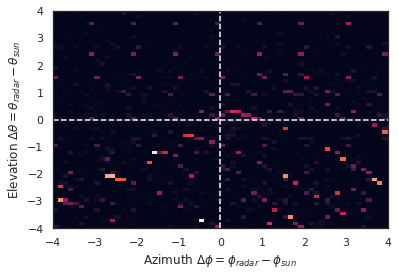

In [11]:
_, _, _, im = pl.hist2d((df.radar_azimuth - df.sun_azimuth), (df.radar_elevation - df.sun_elevation),  range=[[-4, 4], [-4, 4]], bins=64)
pl.axvline(0, color='w', linestyle='dashed')
pl.axhline(0, color='w', linestyle='dashed')
pl.ylabel(r'Elevation $\Delta \theta = \theta_{radar} - \theta_{sun}$')
pl.xlabel(r'Azimuth $\Delta \phi = \phi_{radar} - \phi_{sun}$')
pl.show()

In [12]:
def get_mode(dset):
    azval, azcnt = mode(dset['radar_azimuth'] - dset['sun_azimuth'])
    elval, elcnt = mode(dset['radar_elevation'] - dset['sun_elevation'])
    
    return azval[0], elval[0], azcnt[0], elcnt[0]

In [13]:
def get_angleoffset(df, nbins=128):
    xe = np.linspace(-4, 4, nbins)
    hist_angles, _, _ = np.histogram2d(df['radar_azimuth'] - df['sun_azimuth'], 
                  df['radar_elevation'] - df['sun_elevation'], 
                  range=[[-4, 4], [-4, 4]],
                  bins=nbins)

    a, b = np.where(hist_angles == hist_angles.max())
    azimax = xe[a[0]] 
    elevmax = xe[b[0]]
    return azimax, elevmax 

In [14]:
azi_offset, elev_offset, azi_count, elev_count = zip(*[get_mode(df)])
azi, elev = zip(*[get_angleoffset(df)])

azi_count = np.array(azi_count)
azi  = np.array(azi)
elev = np.array(elev)

Text(0.5, 0, 'Azimuth $\\Delta \\phi = \\phi_{radar} - \\phi_{sun}$')

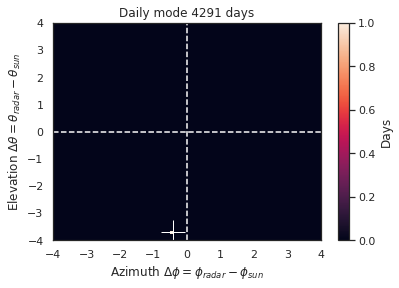

In [15]:
pl.hist2d(azi, elev, range=[[-4, 4], [-4, 4]], bins=64)
pl.title(f'Daily mode {len(flist)} days')
pl.plot(azi[azi_count > 100].mean(), elev[azi_count > 100].mean(), 'w+', label='Monthly mean', markersize=24)
pl.axvline(0, color='w', linestyle='dashed')
pl.axhline(0, color='w', linestyle='dashed')
# pl.legend(loc=2)
pl.colorbar(label='Days')
pl.ylabel(r'Elevation $\Delta \theta = \theta_{radar} - \theta_{sun}$')
pl.xlabel(r'Azimuth $\Delta \phi = \phi_{radar} - \phi_{sun}$')
# pl.savefig('solar_2018_oceanpol.png', dpi=100)